In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os
import sys
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from torchvision import transforms
from PIL import Image
import torch
import warnings
warnings.filterwarnings("ignore")

### Dataset Distribution PieCharts

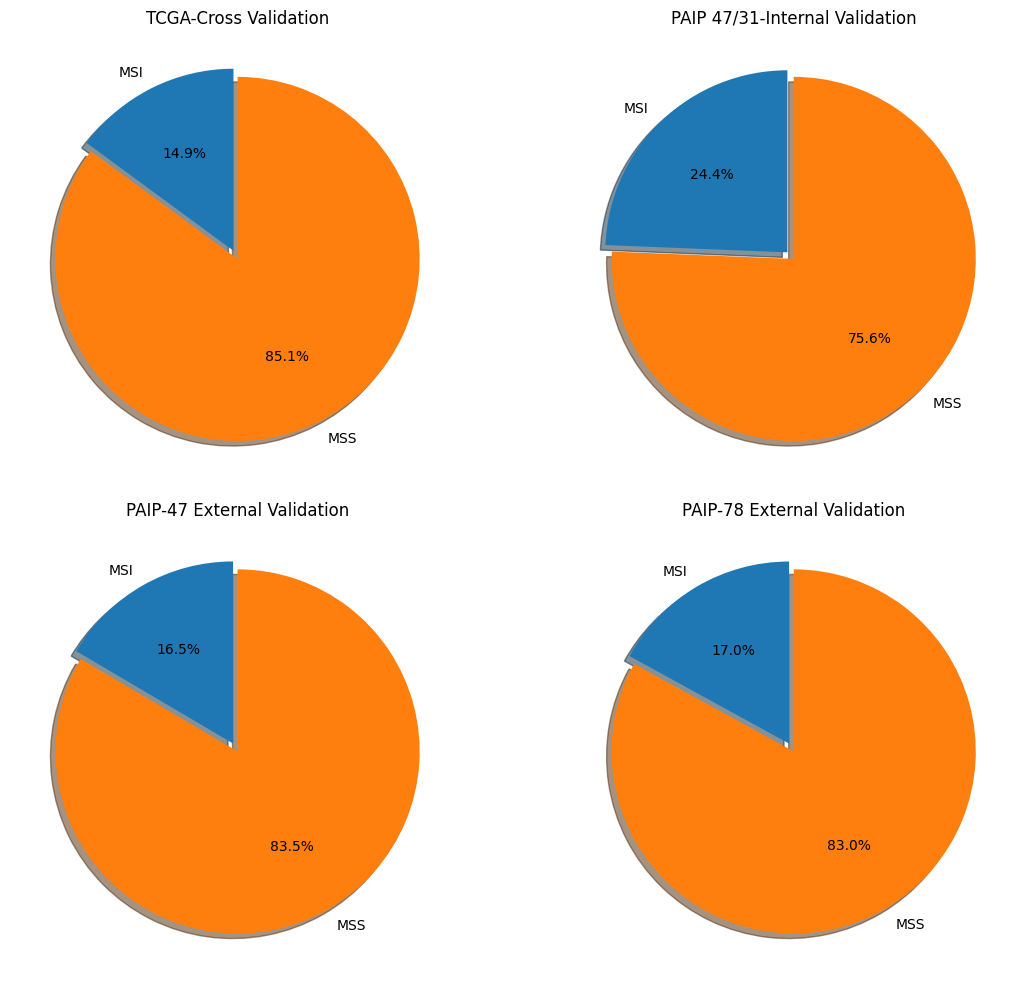

In [ ]:
import matplotlib.pyplot as plt

# Data for the four validation types
cross_validation = [348,61]
internal_validation = [59,19]
external_validation_1 = [12,35]
external_validation_2 = [19,59]

# Labels for the categories
labels = ['MSI', 'MSS']
explode = (0.05, 0)
# Plotting the pie charts
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Cross-validation pie chart
axs[0, 0].pie([61,348], labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)
axs[0, 0].set_title('TCGA-Cross Validation')

# Internal validation pie chart
axs[0, 1].pie([19,59], labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)
axs[0, 1].set_title('PAIP 47/31-Internal Validation')

# External validation 1 pie chart
axs[1, 0].pie([58,293], labels=labels, autopct='%1.1f%%', startangle=90,  explode=explode, shadow=True)
axs[1, 0].set_title('PAIP-47 External Validation')

# External validation 2 pie chart
axs[1, 1].pie([65,317], labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)
axs[1, 1].set_title('PAIP-78 External Validation')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


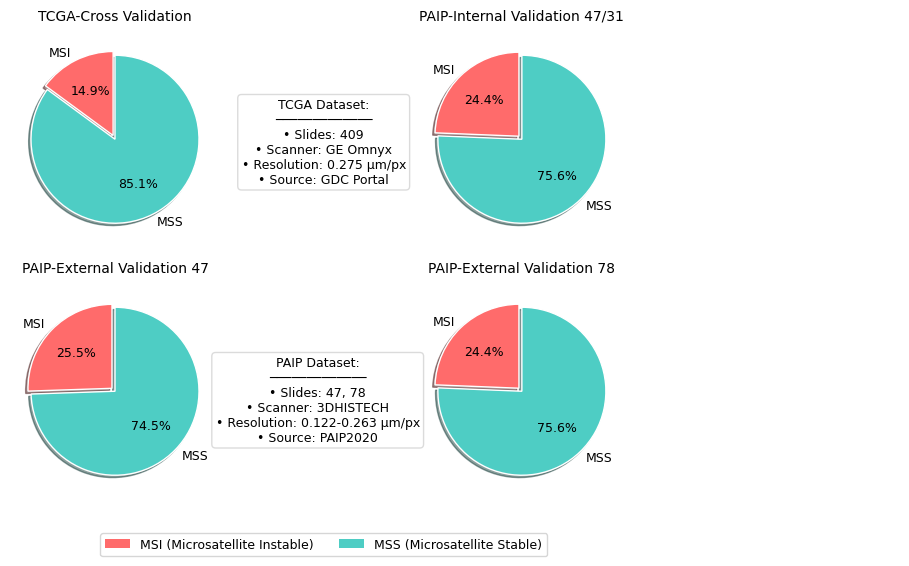

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Data configuration
datasets = {
    "TCGA-Cross Validation": {
        "values": [61,348],
        "type": "TCGA"
    },
    "PAIP-Internal Validation 47/31": {
        "values": [19,59],
        "type": "PAIP"
    },
    "PAIP-External Validation 47": {
        "values": [12,35],
        "type": "PAIP"
    },
    "PAIP-External Validation 78": {
        "values": [19,59],
        "type": "PAIP"
    }
}

# Dataset metadata
dataset_info = {
    "TCGA": {
        "Slides": "409",
        "Scanner": "GE Omnyx",
        "MPP": "0.275 µm/px",
        "Source": "GDC Portal"
    },
    "PAIP": {
        "Slides": ["47", "78"],
        "Scanner": "3DHISTECH",
        "MPP": "0.122-0.263 µm/px",
        "Source": "PAIP2020"
    }
}

# Color scheme
colors = {
    "MSI": "#FF6B6B",  # Coral
    "MSS": "#4ECDC4",   # Teal
    "text": "#333333"
}

# Create compact figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.4],wspace=0.5)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # TCGA pie
ax2 = fig.add_subplot(gs[0, 1])  # PAIP-Int pie
ax3 = fig.add_subplot(gs[1, 0])  # PAIP-Ext1 pie
ax4 = fig.add_subplot(gs[1, 1])  # PAIP-Ext2 pie
ax_info1 = fig.add_subplot(gs[0, 2])  # TCGA info
ax_info2 = fig.add_subplot(gs[1, 2])  # PAIP info

# Turn off info axes
for ax in [ax_info1, ax_info2]:
    ax.axis('off')

# Plot pie charts
for ax, (title, data) in zip([ax1, ax2, ax3, ax4], datasets.items()):
    wedges, texts, autotexts = ax.pie(
        data["values"],
        labels=['MSI', 'MSS'],
        colors=[colors["MSI"], colors["MSS"]],
        autopct='%1.1f%%',
        startangle=90,
        explode=(0.05, 0),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 9},
        shadow=True
    )
    ax.set_title(title, fontsize=10, pad=10)

# Add TCGA info
tcga_text = "\n".join([
    "TCGA Dataset:",
    "─────────────",
    f"• Slides: {dataset_info['TCGA']['Slides']}",
    f"• Scanner: {dataset_info['TCGA']['Scanner']}",
    f"• Resolution: {dataset_info['TCGA']['MPP']}",
    f"• Source: {dataset_info['TCGA']['Source']}"
])
fig.text(0.42, 0.70, tcga_text,
         ha='center', va='center',
         fontsize=9,
         bbox=dict(facecolor='white', alpha=0.8,
                   edgecolor='lightgray', boxstyle='round'))

# Add PAIP info
paip_text = "\n".join([
    "PAIP Dataset:",
    "─────────────",
    f"• Slides: {', '.join(dataset_info['PAIP']['Slides'])}",
    f"• Scanner: {dataset_info['PAIP']['Scanner']}",
    f"• Resolution: {dataset_info['PAIP']['MPP']}",
    f"• Source: {dataset_info['PAIP']['Source']}"
])

fig.text(0.415, 0.27, paip_text,
         ha='center', va='center',
         fontsize=9,
         bbox=dict(facecolor='white', alpha=0.8,
                   edgecolor='lightgray', boxstyle='round'))
# Add legend
legend_elements = [
    plt.Rectangle((0,0), 1, 1, fc=colors["MSI"], label="MSI (Microsatellite Instable)"),
    plt.Rectangle((0,0), 1, 1, fc=colors["MSS"], label="MSS (Microsatellite Stable)")
]
fig.legend(handles=legend_elements, 
           loc='lower center', 
           ncol=2,
           frameon=True,
           fontsize=9,
           bbox_to_anchor=(0.42, -0.00001))

plt.tight_layout()
plt.savefig("data_distribution_piecharts.png", dpi=300, bbox_inches='tight')
plt.show()

### Dataset Feature Analysis using TSNE Plots

In [3]:
# read csv file of WSI
wsi_df = pd.read_csv(r"E:\KSA Project\dataset\paip_data\labels\paip_reviewed_slides.csv")
# set the WSI_Id column and select first 10 values and convert it into list
wsi_id_list = wsi_df["WSI_Id"].tolist()
feature_dir = r"E:\KSA Project\dataset\paip_data\CONCH_FiveCrop_Features"  # Feature directory
output_dir = r"E:\KSA Project\KSAproject_pipeline1\Analysis_Visualization\TSNE_Plots"
# create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

In [4]:
from sklearn.manifold import TSNE

def plot_tsne(msih_features, nonmsih_features, title="t-SNE of WSI level Avg Features"):
    """
    Plots t-SNE for top-ranked patches of all WSIs.
    Args:
      msih_features (numpy.ndarray): Top patch features for MSI-H WSIs.
      nonmsih_features (numpy.ndarray): Top patch features for nonMSI-H WSIs.
    """
    print("Computing t-SNE...")

    # Concatenate MSI-H and nonMSI-H features
    all_features = []
    labels = []

    if msih_features is not None:
        all_features.append(msih_features)
        labels.extend(["MSIH"] * len(msih_features))

    if nonmsih_features is not None:
        all_features.append(nonmsih_features)
        labels.extend(["nonMSIH"] * len(nonmsih_features))

    if not all_features:
        print("⚠️ No data to plot.")
        return

    all_features = np.vstack(all_features)  # Convert to NumPy array

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
    features_2d = tsne.fit_transform(all_features)

    # Plot results
    plt.figure(figsize=(8, 6))
    for label, color in zip(["MSIH", "nonMSIH"], ["red", "blue"]):
        indices = np.where(np.array(labels) == label)[0]
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 
                    color=color, alpha=0.7, label=label)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    # save the plot
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.show()

### Average feature vector Tsne Plot

Error in loading features for TCGA-CM-5868_nonMSIH, skipping...
Error in loading features for TCGA-CI-6624_nonMSIH, skipping...
Error in loading features for TCGA-DM-A280_nonMSIH, skipping...
Error in loading features for TCGA-AY-A71X_nonMSIH, skipping...
Error in loading features for TCGA-CM-5860_nonMSIH, skipping...
Error in loading features for TCGA-DC-6155_nonMSIH, skipping...
Error in loading features for TCGA-AF-2690_nonMSIH, skipping...
Error in loading features for TCGA-AF-A56K_nonMSIH, skipping...
Error in loading features for TCGA-QG-A5YW_nonMSIH, skipping...
Error in loading features for TCGA-CM-6163_nonMSIH, skipping...
Error in loading features for TCGA-D5-6920_nonMSIH, skipping...
Computing t-SNE...


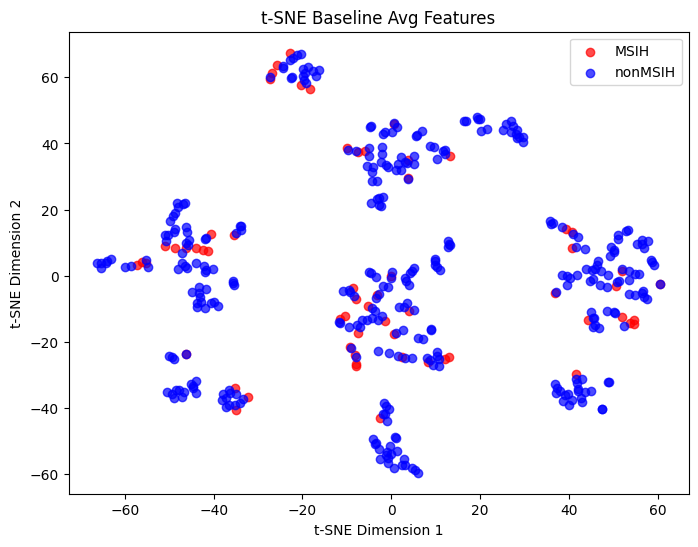

In [ ]:
def compute_wsi_level_features(wsi_id_list, feature_dir, wsi_df):
    msih_features = []
    nonmsih_features = []
    for wsi_id in wsi_id_list:
        # --- Lookup WSI label ---
        row = wsi_df.loc[wsi_df["WSI_Id"] == wsi_id]
        if len(row) < 1:
            print(f"⚠️ No label found for {wsi_id}, skipping...")
            continue
        wsi_label = row.iloc[0]["label"]  # Either "MSIH" or "nonMSIH"
        # --- Load WSI-level features ---
        feature_dir_path = os.path.join(feature_dir, wsi_id)
        try:
            if os.path.isdir(feature_dir_path):
                feature_files = [f for f in os.listdir(feature_dir_path) if f.endswith('.pt')]
                patch_features = []
                for ffile in feature_files:
                    path = os.path.join(feature_dir_path, ffile)
                    feat_5crops = torch.load(path)  # shape [5, D]
                    # first check if the loaded feature vector is already averaged means it is a patch feature
                    if len(feat_5crops.shape) > 1:
                        avg_patch_feature = feat_5crops.mean(dim=0).cpu().numpy()
                        patch_features.append(avg_patch_feature)
                    else:
                        avg_patch_feature = feat_5crops.cpu().numpy()
                        patch_features.append(avg_patch_feature)
                if len(patch_features) == 0:
                    print(f"No patch features found for {wsi_id}, skipping...")
                    continue
                # Average patch features to get WSI-level feature
                wsi_feature = np.mean(np.stack(patch_features), axis=0)  # shape [D]
            else:
                feature_dir_path = feature_dir_path + ".pt"
                wsi_feature = torch.load(feature_dir_path).cpu().numpy()
        except:
            print(f"Error in loading features for {wsi_id}, skipping...")
            continue
        # Store in the appropriate category
        if wsi_label == "MSIH":
            msih_features.append(wsi_feature)
        else:
            nonmsih_features.append(wsi_feature)
    return np.array(msih_features), np.array(nonmsih_features)

msih_features, nonmsih_features = compute_wsi_level_features(wsi_id_list, feature_dir, wsi_df)
plot_tsne(msih_features, nonmsih_features, title="t-SNE Baseline Avg Features")

### All WSIs tsne plot using top patches through clustering

Processing WSI: training_data_02_nonMSIH
Processing WSI: training_data_05_MSIH
Processing WSI: training_data_12_MSIH
Processing WSI: training_data_13_nonMSIH
Processing WSI: validation_data_04_MSIH
Processing WSI: validation_data_05_nonMSIH
Processing WSI: validation_data_08_nonMSIH
Processing WSI: validation_data_11_MSIH
Computing t-SNE...


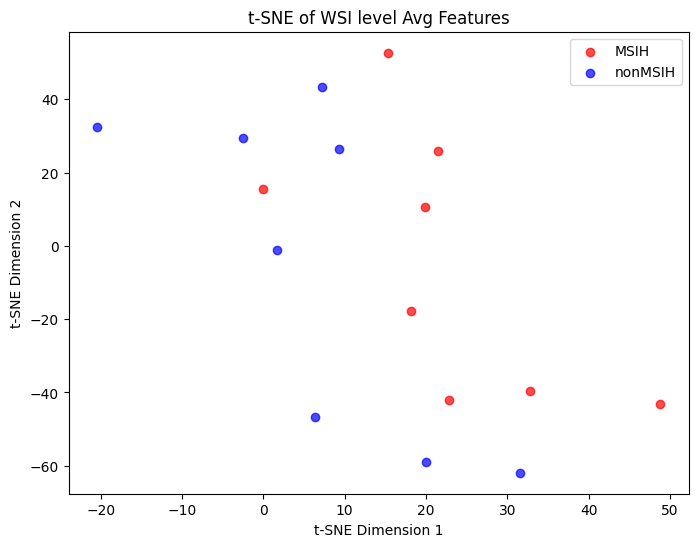

In [ ]:
def select_top_patches_from_clusters(
    patch_array,  # shape [N, D], one vector per patch
    patch_filenames,
    wsi_label,  # Either "MSIH" or "nonMSIH"
    num_clusters=2,
    num_patches_per_cluster=1
):
    """
    Performs clustering and selects top representative patches from **both clusters**.
    Args:
        patch_array (np.array): Array of patch feature vectors.
        patch_filenames (list): List of patch filenames corresponding to the feature vectors.
        wsi_label (str): Either "MSIH" or "nonMSIH" to categorize patches.
        num_clusters (int): Number of clusters.
        num_patches_per_cluster (int): Number of patches to pick **per cluster**.
    Returns:
        selected_patch_files (list): Filenames of selected patches.
        selected_patch_features (list): Feature vectors of selected patches.
        cluster_labels (list): Cluster assignment for selected patches.
    """
    # Perform K-Means clustering
    clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
    clustering_model.fit(patch_array)
    cluster_labels = clustering_model.labels_
    cluster_centroids = clustering_model.cluster_centers_
    selected_patch_files = []
    selected_patch_features = []
    selected_patch_clusters = []  # Stores cluster labels for selected patches

    for cluster_idx in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster_idx)[0]
        if len(cluster_indices) == 0:
            continue  # Skip empty clusters

        # Compute distances from centroid
        cluster_patches = patch_array[cluster_indices]
        cluster_patch_files = [patch_filenames[i] for i in cluster_indices]
        distances = cdist(cluster_patches, [cluster_centroids[cluster_idx]], metric='euclidean').flatten()

        # Sort patches by proximity to centroid
        sorted_indices = np.argsort(distances)
        selected_indices = sorted_indices[:num_patches_per_cluster]  # Pick **top patches** per cluster

        # Store selected patches
        for i in selected_indices:
            selected_patch_files.append(cluster_patch_files[i])
            selected_patch_features.append(patch_array[cluster_indices[i]])
            selected_patch_clusters.append(cluster_idx)  # Store cluster assignment

    return selected_patch_files, selected_patch_features, selected_patch_clusters

def display_top_patches_and_store_features(
    wsi_id_list, feature_dir, wsi_df, output_dir, num_clusters=2
):
    """
    Process all WSIs, extract **only top-ranked patches**, and store their features 
    separately for MSI-H and nonMSI-H. These features will be used for t-SNE plotting.
    """
    os.makedirs(output_dir, exist_ok=True)

    msih_features = []
    nonmsih_features = []
    msih_labels = []  # Cluster assignments for MSI-H patches
    nonmsih_labels = []  # Cluster assignments for nonMSI-H patches

    for wsi_id in wsi_id_list:
        print(f"Processing WSI: {wsi_id}")

        # --- Lookup label ---
        row = wsi_df.loc[wsi_df["WSI_Id"] == wsi_id]
        if len(row) < 1:
            print(f"⚠️ No label found for WSI: {wsi_id}, skipping...")
            continue
        wsi_label = row.iloc[0]["label"]  # Either "MSIH" or "nonMSIH"
        # Set the number of patches to select per cluster
        num_patches_per_cluster = 1  

        # -------------------------------------------------------------------
        # A) LOAD FIVE-CROP FEATURES
        # -------------------------------------------------------------------
        feature_dir_path = os.path.join(feature_dir, wsi_id)
        if not os.path.isdir(feature_dir_path):
            print(f"Feature dir not found for {wsi_id}, skipping.")
            continue
        try:
            if os.path.isdir(feature_dir_path):
                feature_files = [f for f in os.listdir(feature_dir_path) if f.endswith('.pt')]
                patch_features = []
                patch_filenames = []
                for ffile in feature_files:
                    path = os.path.join(feature_dir_path, ffile)
                    feat_5crops = torch.load(path)  # shape [5, D]
                    # first check if the loaded feature vector is already averaged means it is a patch feature
                    if len(feat_5crops.shape) > 1:
                        avg_patch_feature = feat_5crops.mean(dim=0).cpu().numpy()
                        patch_features.append(avg_patch_feature)
                    else:
                        avg_patch_feature = feat_5crops.cpu().numpy()
                        patch_features.append(avg_patch_feature)
                    patch_filenames.append(ffile.replace('.pt', '.png'))

                if len(patch_features) == 0:
                    print(f"No patch features found for {wsi_id}, skipping...")
                    continue
                # Average patch features to get WSI-level feature
                wsi_feature = np.mean(np.stack(patch_features), axis=0)  # shape [D]
            else:
                feature_dir_path = feature_dir_path + ".pt"
                wsi_feature = torch.load(feature_dir_path).cpu().numpy()
        except:
            print(f"Error in loading features for {wsi_id}, skipping...")
            continue

        # -------------------------------------------------------------------
        # B) AVERAGE sub-crops to get [D] per patch (for K-Means)
        # -------------------------------------------------------------------
        # patch_array_for_clustering = patch_features  # shape [N, D]
        patch_array_for_clustering = np.stack(patch_features, axis=0)  # shape [N, D]

        # -------------------------------------------------------------------
        # C) K-Means, pick top patches
        # -------------------------------------------------------------------
        selected_files, selected_features, selected_clusters = select_top_patches_from_clusters(
            patch_array_for_clustering,
            patch_filenames,
            wsi_label,
            num_clusters=num_clusters,
            num_patches_per_cluster=num_patches_per_cluster
        )

        # -------------------------------------------------------------------
        # D) STORE SELECTED FEATURES FOR t-SNE
        # -------------------------------------------------------------------
        for feature, cluster_idx in zip(selected_features, selected_clusters):
            if wsi_label == "MSIH":
                msih_features.append(feature)
                msih_labels.append(cluster_idx)
            else:
                nonmsih_features.append(feature)
                nonmsih_labels.append(cluster_idx)

    # Convert lists to NumPy arrays
    msih_features = np.array(msih_features) if msih_features else None
    nonmsih_features = np.array(nonmsih_features) if nonmsih_features else None

    return msih_features, nonmsih_features, msih_labels, nonmsih_labels

msih_features, nonmsih_features, msih_labels, nonmsih_labels = display_top_patches_and_store_features(
    wsi_id_list, feature_dir, wsi_df, output_dir, num_clusters=2)

plot_tsne(msih_features, nonmsih_features)

### One WSI tSNE plot using kmeans cluster to assign different color to datapoints

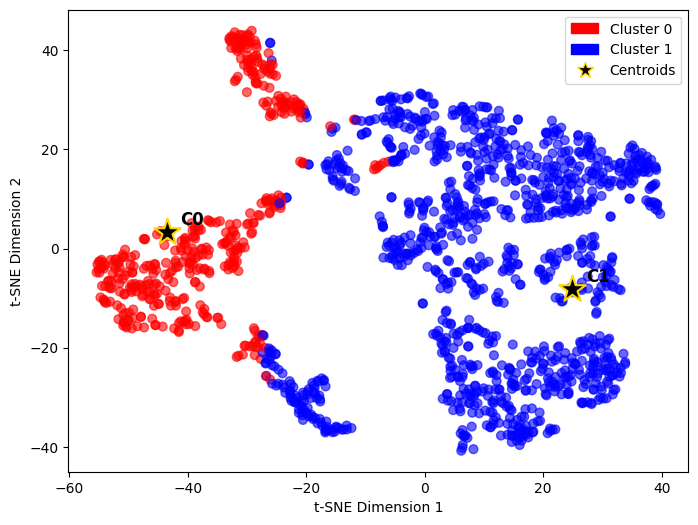

Centroid patches:
cluster_0: training_data_02_nonMSIH_x23040_y14336_1414.png
cluster_1: training_data_02_nonMSIH_x8192_y3072_464.png


In [13]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

def plot_tsne_for_single_wsi(wsi_id, feature_dir, num_clusters=2, output_dir='.'):
    """
    Runs K-Means on all patches of a single WSI and visualizes clusters using t-SNE.
    Identifies and marks centroid patches for each cluster.
    
    Args:
        wsi_id (str): WSI identifier.
        feature_dir (str): Path to WSI feature directory.
        num_clusters (int): Number of clusters for patch grouping.
        output_dir (str): Directory to save output figures.
        
    Returns:
        dict: Dictionary mapping cluster IDs to their centroid patch filenames
    """
    feature_dir_path = os.path.join(feature_dir, wsi_id)
    if not os.path.isdir(feature_dir_path):
        print(f"Feature directory not found for {wsi_id}.")
        return None

    try:
        if os.path.isdir(feature_dir_path):
            feature_files = [f for f in os.listdir(feature_dir_path) if f.endswith('.pt')]
            patch_features = []
            patch_filenames = []
            for ffile in feature_files:
                path = os.path.join(feature_dir_path, ffile)
                feat_5crops = torch.load(path)
                if len(feat_5crops.shape) > 1:
                    avg_patch_feature = feat_5crops.mean(dim=0).cpu().numpy()
                    patch_features.append(avg_patch_feature)
                else:
                    avg_patch_feature = feat_5crops.cpu().numpy()
                    patch_features.append(avg_patch_feature)
                patch_filenames.append(ffile.replace('.pt', '.png'))

            if len(patch_features) == 0:
                print(f"No patch features found for {wsi_id}, skipping...")
                return None
                
            patch_array = np.stack(patch_features)  # shape [N, D]
    except Exception as e:
        print(f"Error in loading features for {wsi_id}: {e}")
        return None
    
    # Apply K-Means to cluster patches within the WSI
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(patch_array)
    
    # Get the indices of patches closest to each centroid
    centroid_patch_indices = []
    for i in range(num_clusters):
        # Get all patches in this cluster
        cluster_patches = patch_array[cluster_labels == i]
        
        # Find distances from each patch to the centroid
        centroid = kmeans.cluster_centers_[i]
        distances = np.linalg.norm(cluster_patches - centroid, axis=1)
        
        # Find the index of the patch with minimum distance (closest to centroid)
        cluster_indices = np.where(cluster_labels == i)[0]
        closest_idx_in_cluster = np.argmin(distances)
        centroid_patch_idx = cluster_indices[closest_idx_in_cluster]
        centroid_patch_indices.append(centroid_patch_idx)

    # Run t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    features_2d = tsne.fit_transform(patch_array)
    
    # Create colormap
    colors = ["red", "blue", "green", "purple", "orange"][:num_clusters]
    two_color_cmap = ListedColormap(colors)
    boundaries = [-0.5 + i for i in range(num_clusters + 1)]
    norm = BoundaryNorm(boundaries, two_color_cmap.N)

    # Plot results
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=cluster_labels, cmap=two_color_cmap,
                         norm=norm, alpha=0.6, s=40)
    
    # Mark centroid patches with special markers
    for i, idx in enumerate(centroid_patch_indices):
        plt.scatter(features_2d[idx, 0], features_2d[idx, 1],
                   c='black', marker='*', s=400, edgecolor='gold',
                   linewidth=1.5, label=f'Centroid Cluster {i}')
        plt.annotate(f'C{i}', xy=(features_2d[idx, 0], features_2d[idx, 1]),
                    xytext=(10, 5), textcoords='offset points',
                    fontsize=12, weight='bold')

    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    # plt.title(f"t-SNE for WSI: {wsi_id}\nCentroids Marked with Stars")
    
    # Create custom legend
    legend_elements = [
        mpatches.Patch(color=colors[i], label=f'Cluster {i}') 
        for i in range(num_clusters)
    ]
    legend_elements.append(
        plt.Line2D([0], [0], marker='*', color='black', label='Centroids',
                  markersize=12, linestyle='None', markeredgecolor='gold')
    )
    plt.legend(handles=legend_elements)
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'tsne_{wsi_id}.png'), 
               bbox_inches='tight', dpi=300)
    plt.show()
    
    # Return the centroid patch filenames for inspection
    centroid_patches = {
        f'cluster_{i}': patch_filenames[idx] 
        for i, idx in enumerate(centroid_patch_indices)
    }
    return centroid_patches

# Example usage
centroid_patches = plot_tsne_for_single_wsi(
    wsi_id="training_data_02_nonMSIH",
    feature_dir=feature_dir,
    num_clusters=2,
    output_dir=output_dir
)

print("Centroid patches:")
for cluster, patch in centroid_patches.items():
    print(f"{cluster}: {patch}")